# Fit the time series with expectation maximization

We fit the time series of alert events with expectation maximization following [M. Karl and P. Eller JCAP07(2024)057](https://iopscience.iop.org/article/10.1088/1475-7516/2024/07/057) and [R. Abbasi et al 2024 ApJ 964 40](https://iopscience.iop.org/article/10.3847/1538-4357/ad18d6).

In [42]:
from collections import deque

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import norm

from utils import go_through_area_multiplet_dict, angular_distance, En, Mn

## Load the alert catalog

In [4]:
alerts = pd.read_csv("../../icecat-1/IceCube_Gold_Bronze_Tracks_Nov2023.csv")
alerts = alerts[~np.bool_(alerts["CR_VETO"])]



In [5]:
alerts_area = np.pi * 0.25 * (alerts["RA_ERR_PLUS"]*np.cos(np.deg2rad(alerts["DEC"])) * 
                              alerts["DEC_ERR_PLUS"] + 
                           abs(alerts["RA_ERR_MINUS"])*np.cos(np.deg2rad(alerts["DEC"])) * 
                              alerts["DEC_ERR_PLUS"] + 
                           abs(alerts["RA_ERR_MINUS"])*np.cos(np.deg2rad(alerts["DEC"])) * 
                              abs(alerts["DEC_ERR_MINUS"]) +
                           alerts["RA_ERR_PLUS"]*np.cos(np.deg2rad(alerts["DEC"])) * 
                              abs(alerts["DEC_ERR_MINUS"]))

In [6]:
alerts.insert(len(alerts.columns), "AREA", alerts_area)

## Get Signal over Background (S/B) weights 

We want to weigh events stronger who are "more signal-like". Meaning: events that are close to our point-source position. We also weigh high-energetic events stronger. 

### Energy

The energy weights are derived from the Signalness. The Signalness is defined as 
$$ S = \frac{ N_{Signal} }{N_{Signal} + N_{Background}} $$
hence we can take $$ \frac{ N_{Signal} }{N_{Background}} = \frac{S}{1-S}$$ as our energy S/B weight.


In [33]:
sob_energy = alerts.SIGNAL / (1 - alerts.SIGNAL)

### Spatial

We get spatial signal weights based on a Rayleigh distribution. 

$$ W_\mathrm{spatial, signal} = \frac{1}{2 \pi \sigma_i^2} \exp \left( \frac{-|x_i - x_S|^2}{2 \sigma_i} \right),$$

with $\sigma_i$ as the event's uncertainty. $|x_i - x_S|$ is the angular distance on the sky between the source position $x_S$ and the event's position $x_i$. 

The background weights assume uniformity in right ascension. Because of Icecube's location at the South Pole and earth's rotation, any dependencies on azimuth angle will average out for integration times longer than a few days. There is however a declination dependency. We consider this by calculating how likely IceCube detects events from a given declination. We get this information from the published effective areas $A_\mathrm{eff}$:

$$ P(\delta_i) = \frac{\sum_E A_\mathrm{eff} (E |\delta_i)} {\sum_{E, \delta_i} A_\mathrm{eff} (E, \delta_i) }, $$

where we take the sum over all energies of all effective areas within one declination band and divide it by the total sum (over all energies and declinations) of the effective areas. So the spatial background weights are: 

$$ W_\mathrm{spatial, background} = \frac{1}{2 \pi} P(\delta_i). $$

Our spatial S/B weight is then $ W_\mathrm{spatial, signal} / W_\mathrm{spatial, background}$ for each event. 

In [28]:
# get effA from IceCat for better background declination weights
effA = pd.read_csv("../../icecat-1/eff_area/Effa_all_streams_gold_bronze.txt", sep="\t")
effA_decs = effA.loc[:,effA.columns != '#E ']

In [29]:
def get_dec_bg_prob(dec, effA_decs):
    # get the probability to detect events based on the effective area and declination
    keys = [' 30-90 ', ' 0-30 ', ' -5-0 ', ' -30--5 ', ' -90--30']
    dec_lim = np.atleast_1d([30, 0, -5, -30, -90])
    dec_bin = np.argmax(dec >= dec_lim)
    
    return effA_decs.sum()[keys[dec_bin]] / sum(effA_decs.sum())
    

In [30]:
#calculate each alert bg prob once, it stays the same. 
dec_bg_prob = []
for mydec in alerts.DEC:
    dec_bg_prob.append(get_dec_bg_prob(mydec, effA_decs))


In [31]:
    
def sob_distance(pos, alerts, tracks_area):
    
    # get angular distance
    ang_dist = angular_distance(np.deg2rad(pos[0]), np.deg2rad(pos[1]), 
                                np.deg2rad(alerts.RA.values), np.deg2rad(alerts.DEC.values))
 
    weight = np.exp(- ang_dist**2 / (tracks_area / np.pi) / 2 ) / 2 / np.pi / (tracks_area / np.pi)
    
    return weight / ((1 / 2 / np.pi) * np.atleast_1d(dec_bg_prob))

## Get the source positions from the multiplet dictionary

In [18]:
multiplets_per_signalness = np.load("../alert_multiplets/signal_multiplets_per_signalness.npy", 
                                    allow_pickle=True).item()

We take the weighted arithmetic circular mean positions as our point-source positions

In [19]:
weighted_x_func, weighted_sigma_func = go_through_area_multiplet_dict(multiplets_per_signalness, alerts)

## Calculate the signal over background values for each source positions

In [34]:
sob_spatial = {}
sob_spatial_energy = {}
for my_area in weighted_x_func:
    tmp_spatial = []
    tmp_spatial_energy = []

    entry = weighted_x_func[my_area]
    for index in entry:
        tmp_spatial.append(sob_distance(entry[index], alerts, alerts_area))
        tmp_spatial_energy.append(tmp_spatial[-1] * sob_energy)
        
    sob_spatial[my_area] = tmp_spatial
    sob_spatial_energy[my_area] = tmp_spatial_energy

In [35]:
np.save("sob_spatial_energy_for_data_signalness.npy", sob_spatial_energy, allow_pickle=True)

## Fit the flares!

In [38]:

# for without weighting, set sob_values to 1
nstart = 10
times = alerts.EVENTMJD.values
number_flares = 20
mean_T = np.linspace(times[0], times[-1], number_flares)
sigma_T = np.array([500]*number_flares)
ns_T = np.array([nstart]*number_flares)
llh1 = deque(range(20), 20)
i = 0


#test for smallest number of weighted pos. 

# run EM until either 500 iterations are complete or the llh did not change the last 20 iterations

llh_flares = {}

for my_area in sob_spatial_energy:
    print(my_area)
#     if float(my_area) >10:
#         continue
        
    tmp_result = []
    
#    area_mask = alerts_area <= float(my_area)
    area_mask = alerts["SIGNAL"].values >= float(my_area)

    for index, weights in enumerate(sob_spatial_energy[my_area]):
        
        # ensure that the sum of all signal neutrinos does not exceed the total number of neutrinos
        if (nstart * number_flares) > len(times[area_mask]):
            if len(times[area_mask]) <= number_flares: # set number of flares to be less than total events
                number_flares = len(times[area_mask]) - 1

            nstart = max(len(times[area_mask]) / number_flares - 1, 0.5) # this should always be positive
        
        mean_T = np.linspace(min(times[area_mask]), max(times[area_mask]), number_flares)
        sigma_T = np.array([500]*number_flares)
        ns_T = np.array([nstart]*number_flares)
        llh1 = deque(range(20), 20)        
        
        i = 0

        while i < 500 and (sum(np.abs(np.diff(llh1))) > 0):
                                
            exp = En(ns_T, mean_T, sigma_T, times[area_mask], weights[area_mask].values, max(times)-min(times), 
                     set_b_term=False)

            mean_T, sigma_T, ns_T = Mn(exp[0], times[area_mask], min_s=10)
            llh1.append(exp[1])
            i += 1
            mean_T, sigma_T, ns_T = np.array(mean_T), np.array(sigma_T), np.array(ns_T)
                    

        tmp_result.append((exp[1], exp[2], mean_T, sigma_T, ns_T))
        print("###### converged ######")
        print("TS = ", -2*(exp[2] - exp[1]))
        
#         plot_time_series(weights, mean_T, sigma_T, ns_T, area_mask)
#         plt.show()
    llh_flares[my_area] = tmp_result


0.414
###### converged ######
TS =  423.48896797149746
###### converged ######
TS =  459.78804059308595
###### converged ######
TS =  484.4447437585254
###### converged ######
TS =  445.5447739046167
###### converged ######
TS =  451.17814423218215
###### converged ######
TS =  422.4220645441642
###### converged ######
TS =  481.73674480026784
###### converged ######
TS =  434.2350443857563
###### converged ######
TS =  460.2031164492196
###### converged ######
TS =  449.4477994689596
###### converged ######
TS =  427.8016391052247
###### converged ######
TS =  435.81788890222424
###### converged ######
TS =  437.536229765843
###### converged ######
TS =  464.2371655550046
###### converged ######
TS =  427.91764187228864
###### converged ######
TS =  449.8370144554424
###### converged ######
TS =  444.19221954923387
0.504
###### converged ######
TS =  394.5939454161489
###### converged ######
TS =  365.08212632107075
###### converged ######
TS =  361.1372710265141
###### converged ####

In [39]:
np.save("llh_flares_signal.npy", llh_flares, allow_pickle=True)

## Plot the flares! 

In [49]:
def plot_time_series(weights, mu, sigma, ns, mask, log=True):
    fs=20
    fig, ax = plt.subplots(figsize=(15,3))
    ax2 = ax.twinx()

    lc = ax.vlines(alerts["EVENTMJD"].values[mask], [0], weights.values[mask], #label=r"log$_{10}$ $S/B$", 
               label=r"alert events")

        
    if log==True:
        ax.set_yscale("log")

    tmp_x = np.linspace(min(alerts["EVENTMJD"][mask].values), max(alerts["EVENTMJD"][mask].values), 10000)
    ax2.plot(tmp_x, 
             np.sum(norm(mu, sigma).pdf(tmp_x.reshape(len(tmp_x), 1)) * ns, axis=-1) , 
             label="time pdf (EM)", alpha=0.7, 
             linewidth=3, color="darkorange")



    ax.set_xlabel("$t_i$ [MJD]")
    ax.set_ylabel(r"$S/B$")
    ax2.set_ylabel(r"$S_{\rm{temp}}(t_i, \mu_T, \sigma_T)$ [a.u.]")

    legend = fig.legend(loc="lower left", bbox_to_anchor=(0,0.95), bbox_transform=ax.transAxes, ncol=2, 
                       fontsize=fs, frameon=False)
    ax.set_ylim(1, max(weights) *1.5)
    
    ax.set_xlabel("$t_i$ [MJD]", fontsize=fs)
    ax.set_ylabel(r"$S/B$", fontsize=fs)
    ax2.set_ylabel(r"$S_{\rm{temp}}(t_i, \mu_T, \sigma_T) [a.u.]$", fontsize=fs)
    ax2.tick_params(labelsize=fs)
    ax.tick_params(axis="both", labelsize=fs)


    return fig


Signalness: 0.414, index: 0


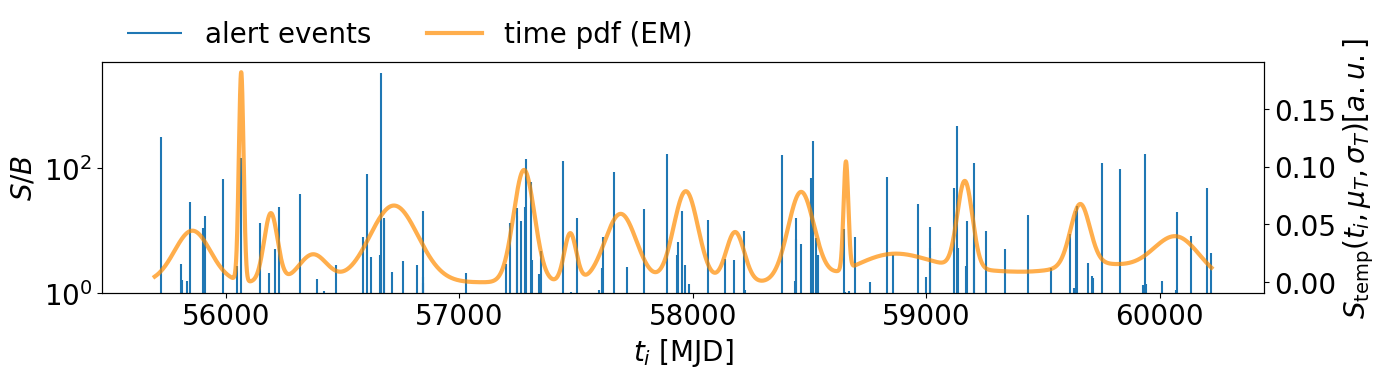

Signalness: 0.414, index: 1


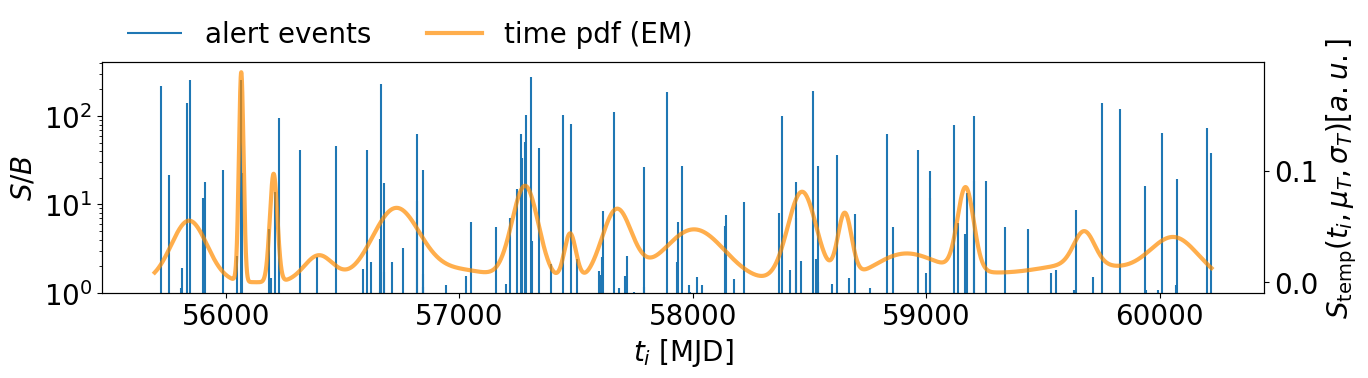

Signalness: 0.414, index: 2


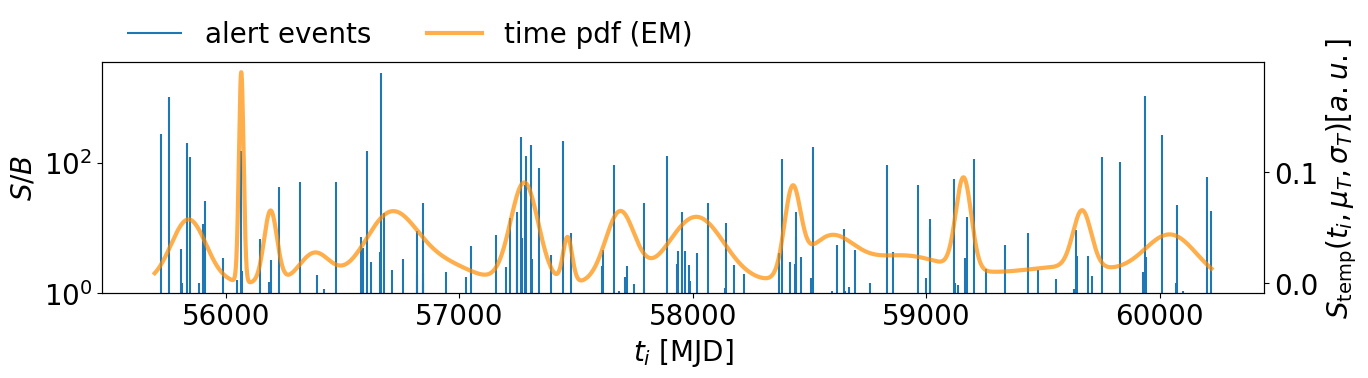

Signalness: 0.414, index: 3


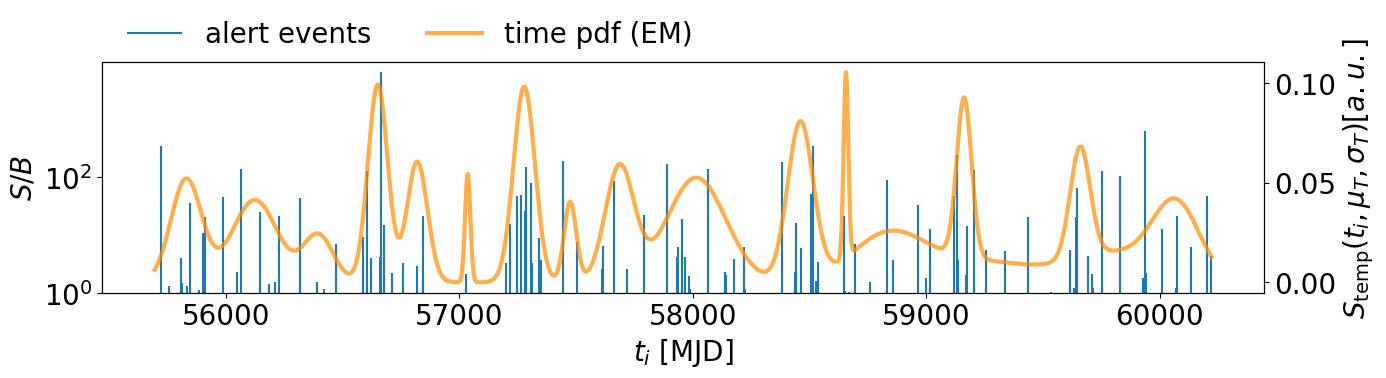

Signalness: 0.414, index: 4


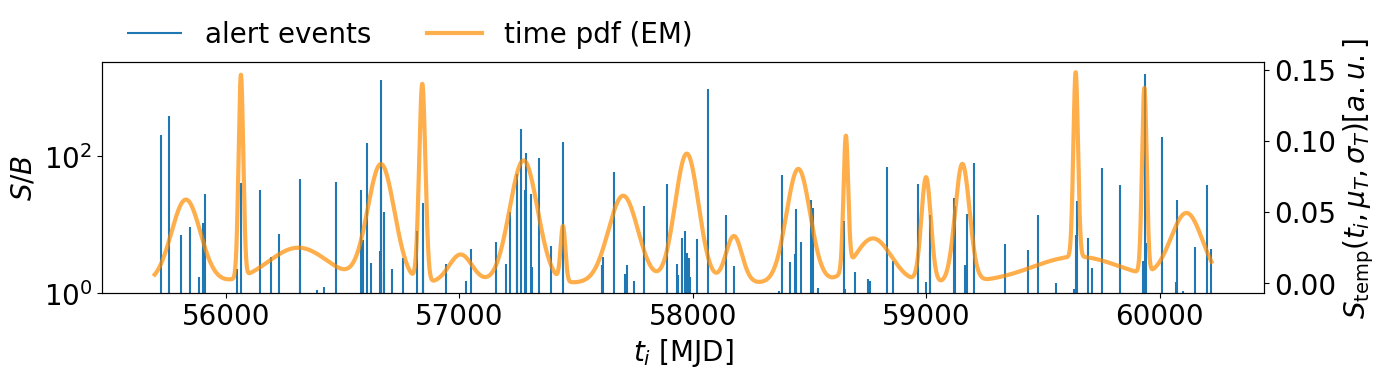

Signalness: 0.414, index: 5


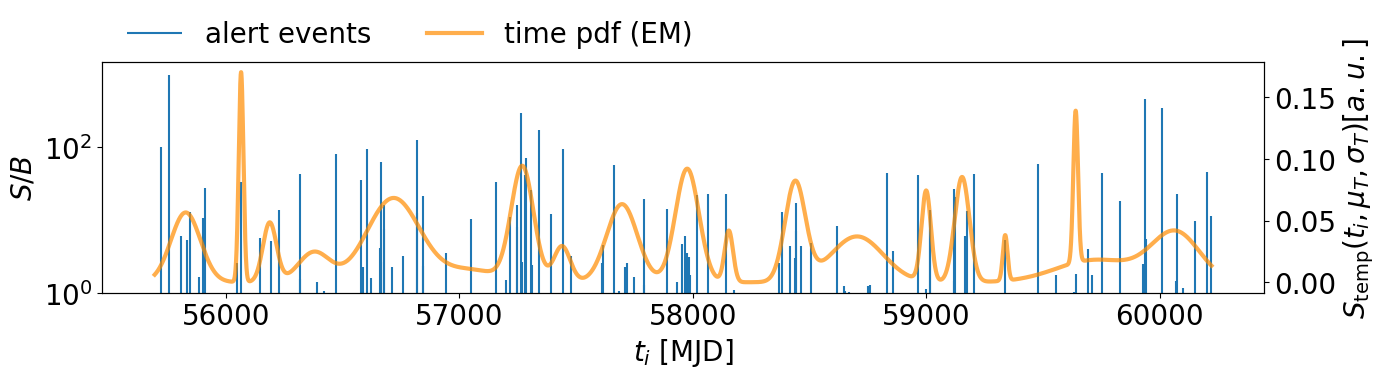

Signalness: 0.414, index: 6


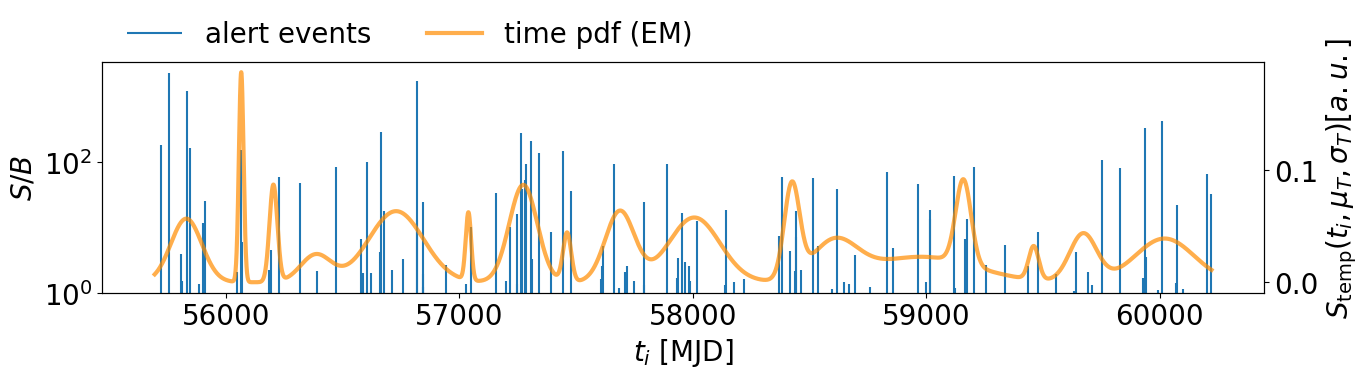

Signalness: 0.414, index: 7


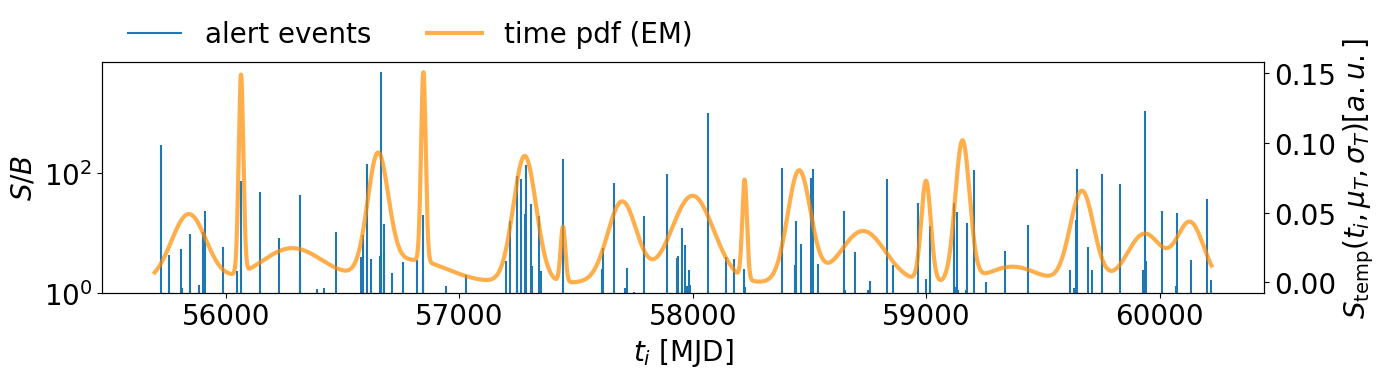

Signalness: 0.414, index: 8


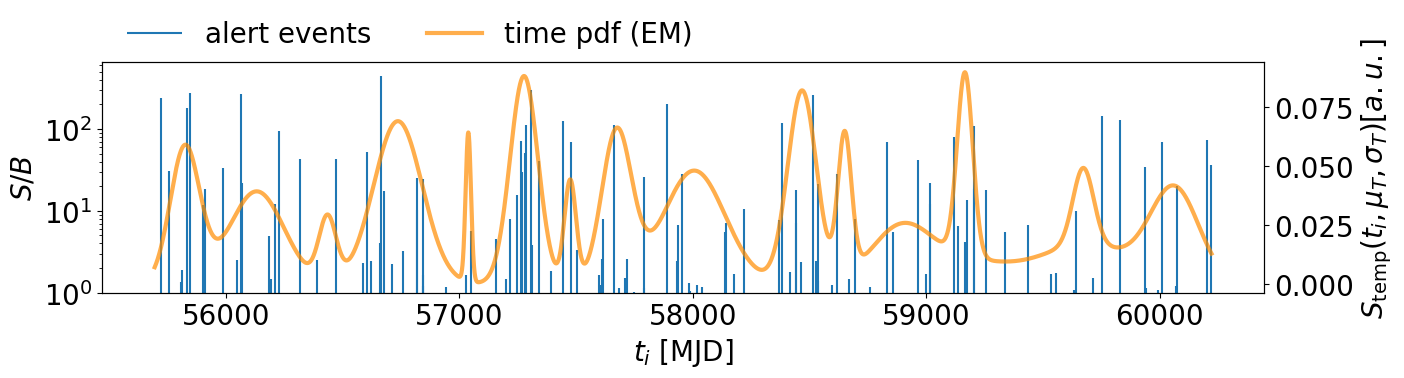

Signalness: 0.414, index: 9


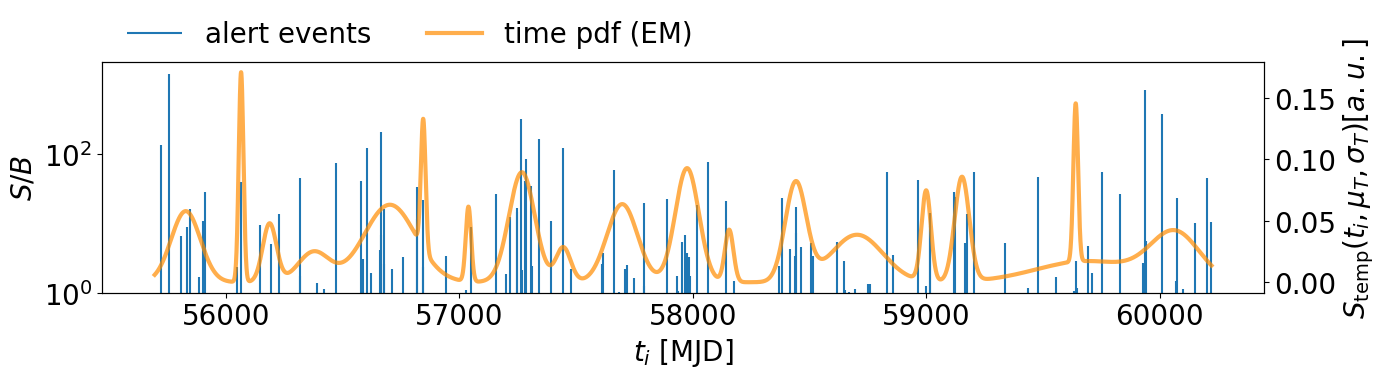

Signalness: 0.414, index: 10


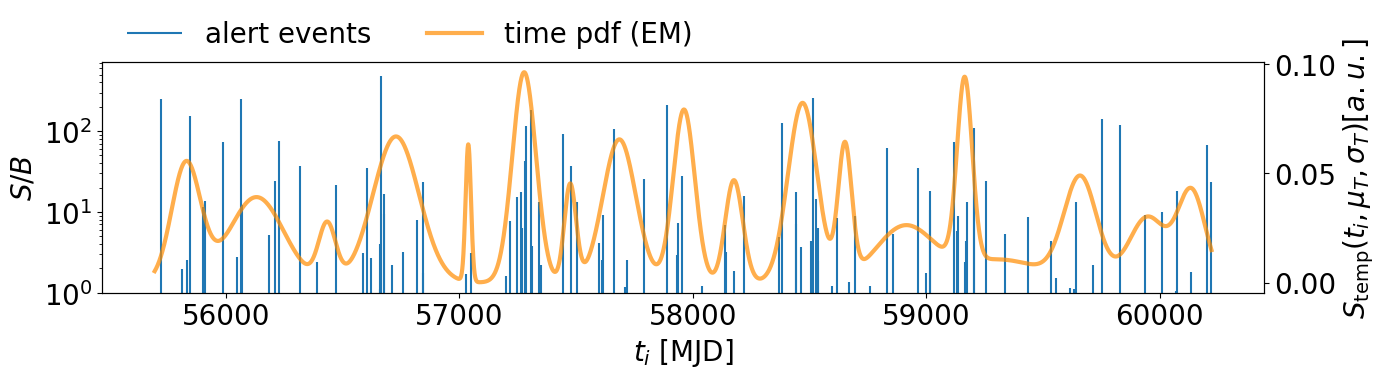

Signalness: 0.414, index: 11


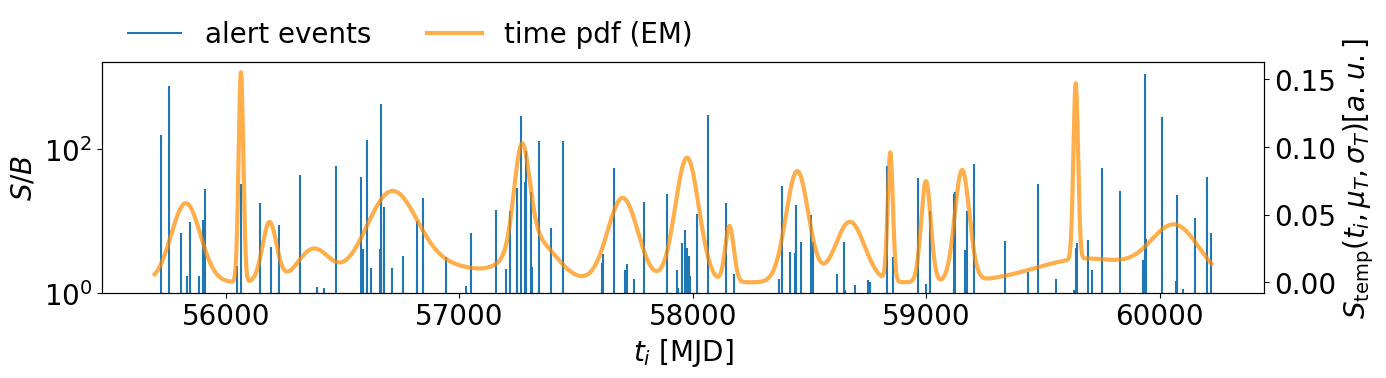

Signalness: 0.414, index: 12


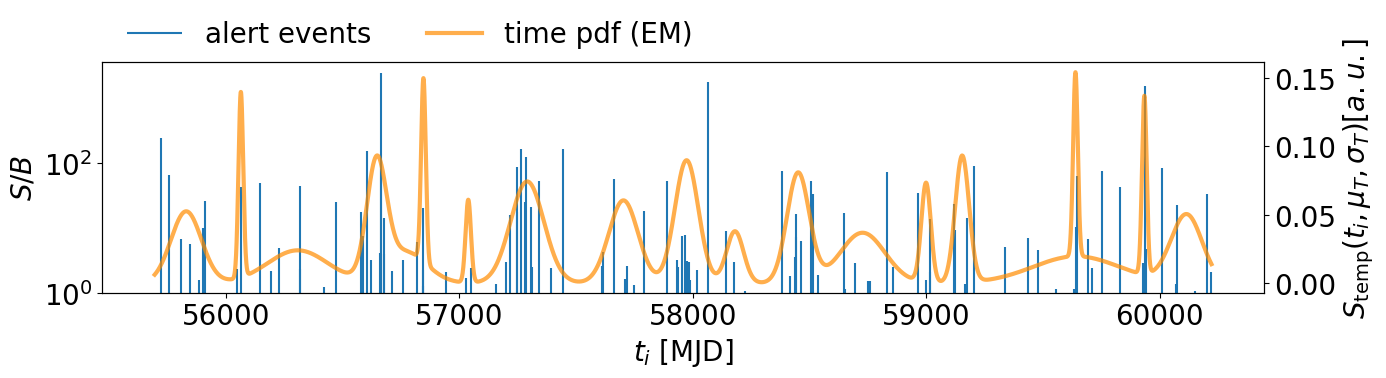

Signalness: 0.414, index: 13


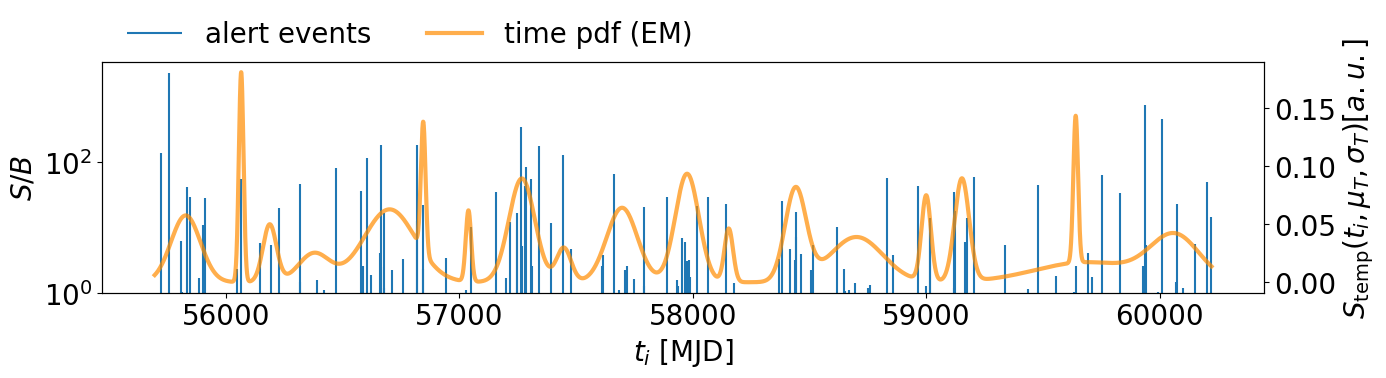

Signalness: 0.414, index: 14


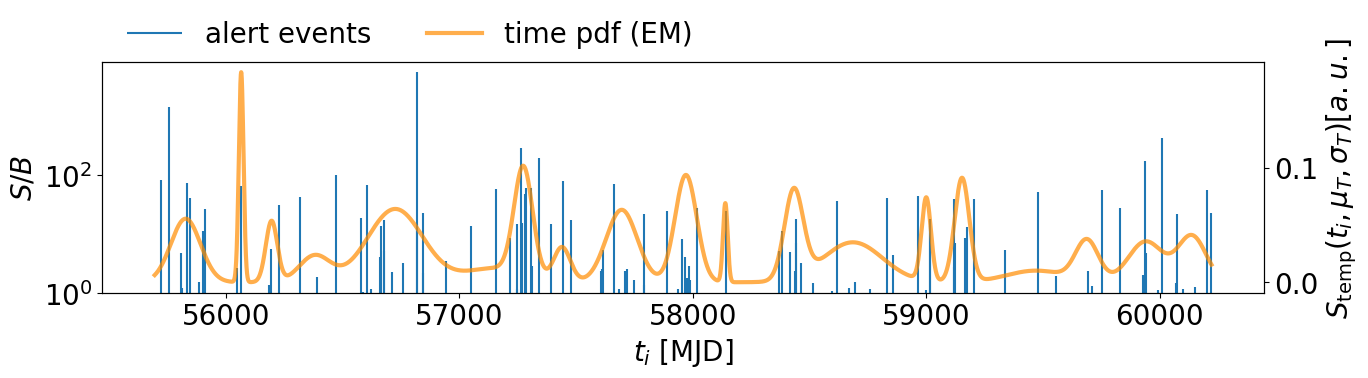

Signalness: 0.414, index: 15


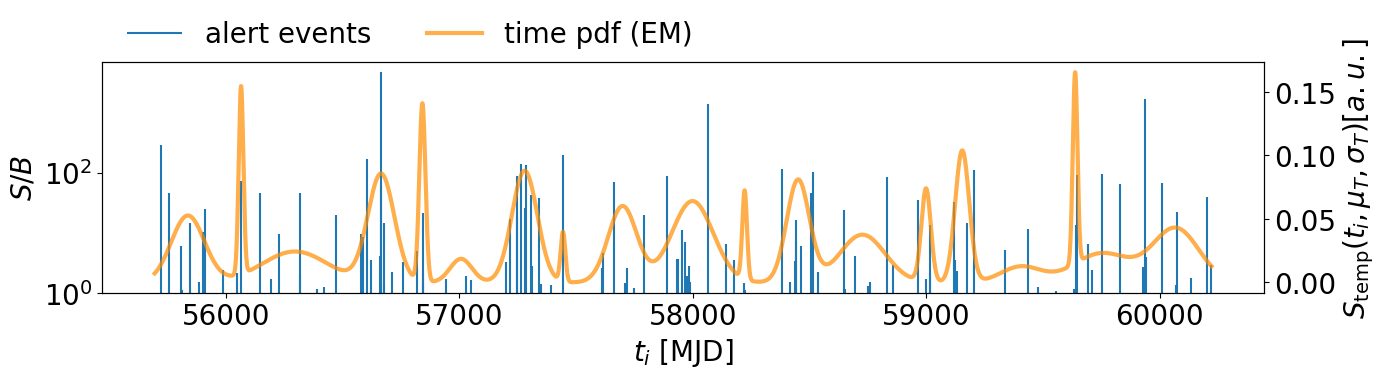

Signalness: 0.414, index: 16


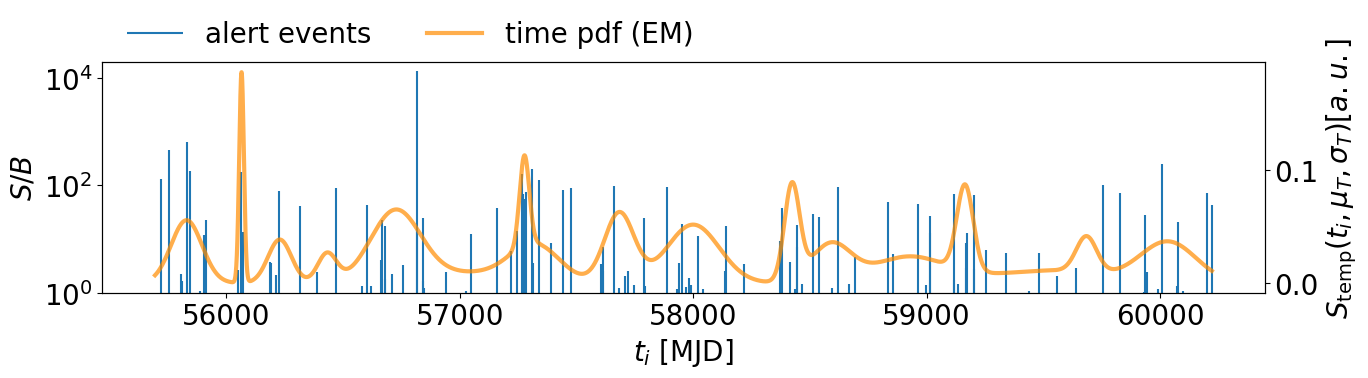

Signalness: 0.504, index: 0


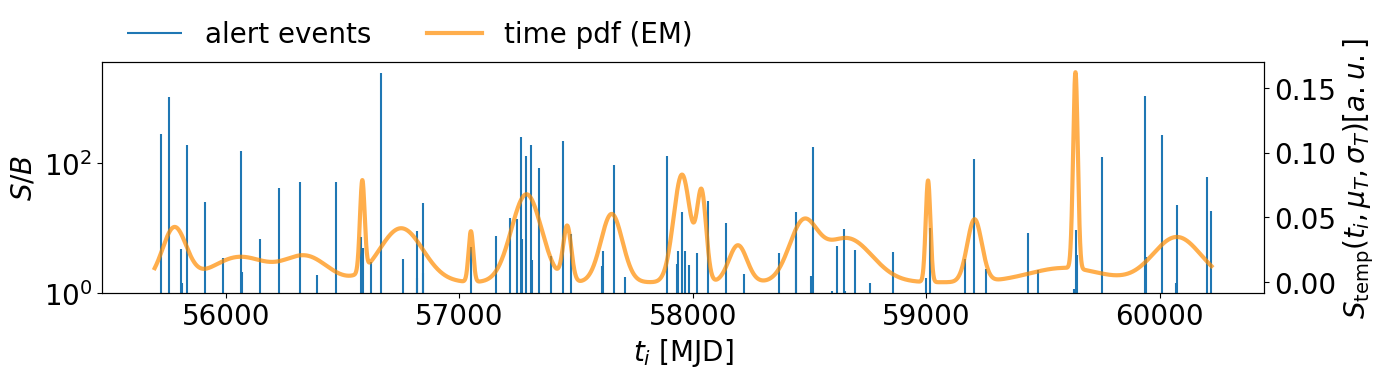

Signalness: 0.504, index: 1


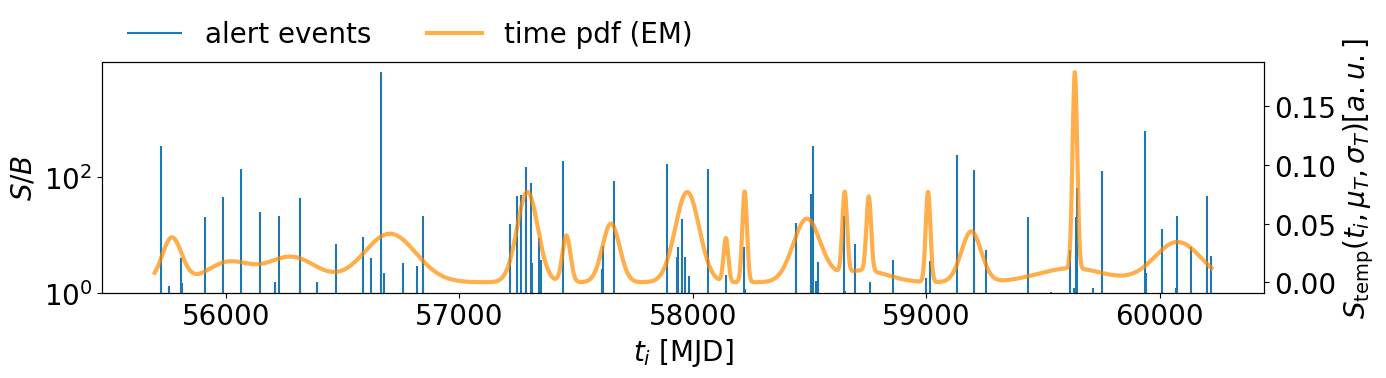

Signalness: 0.504, index: 2


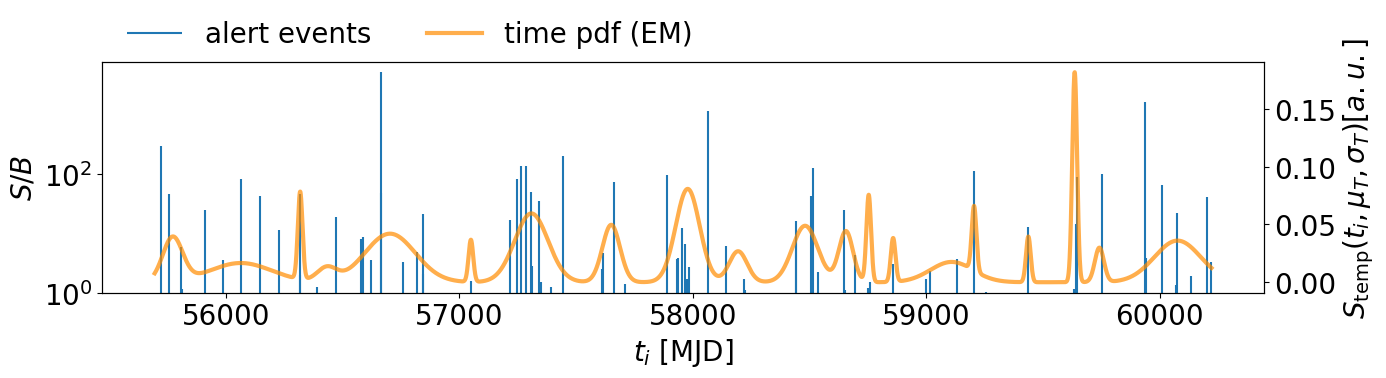

Signalness: 0.504, index: 3


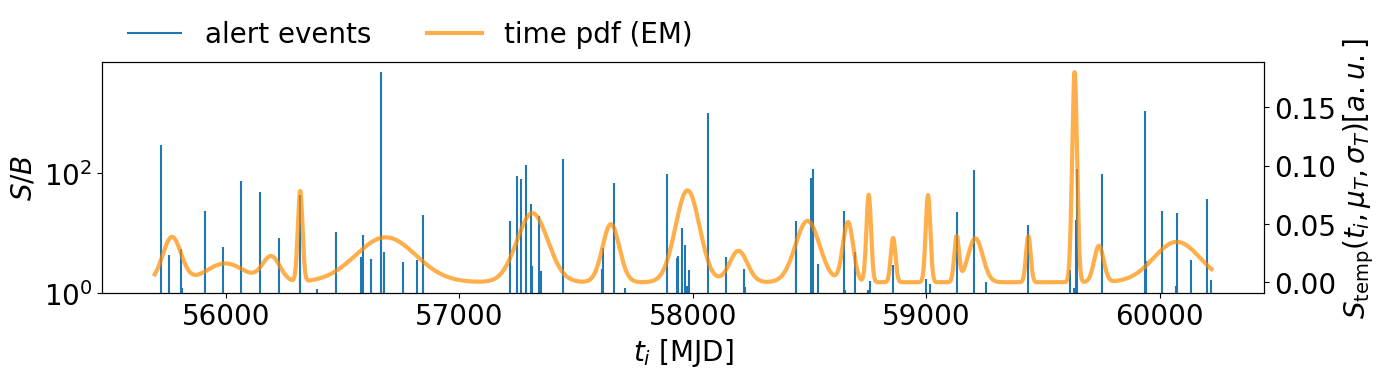

Signalness: 0.453, index: 0


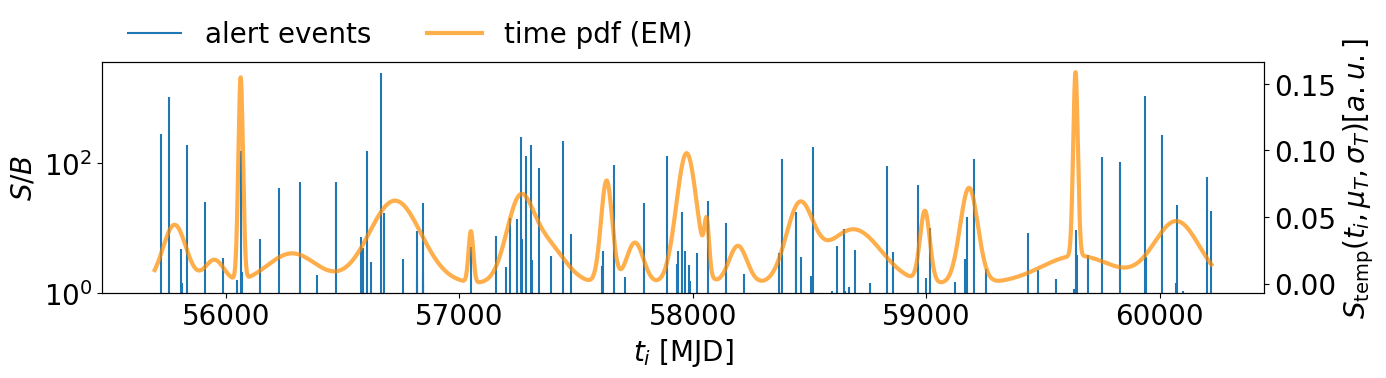

Signalness: 0.453, index: 1


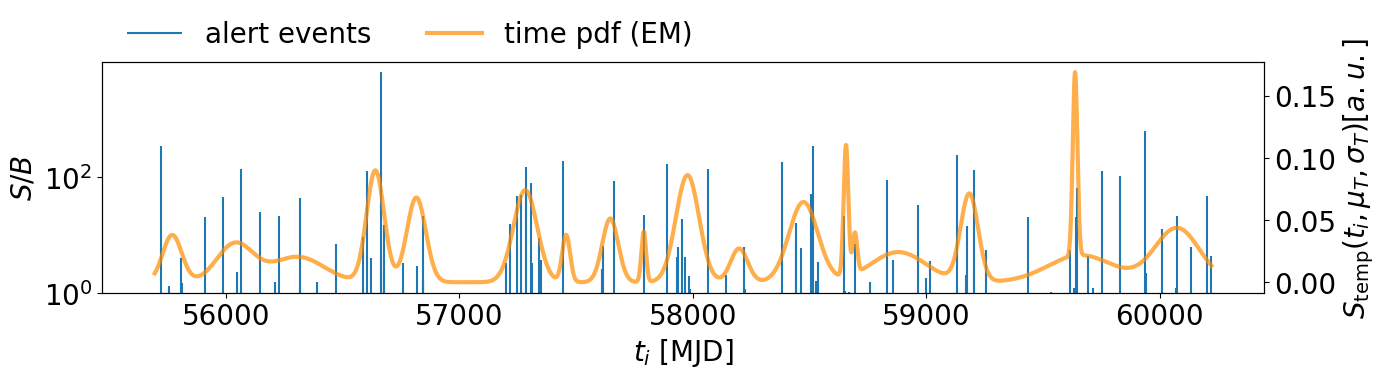

Signalness: 0.453, index: 2


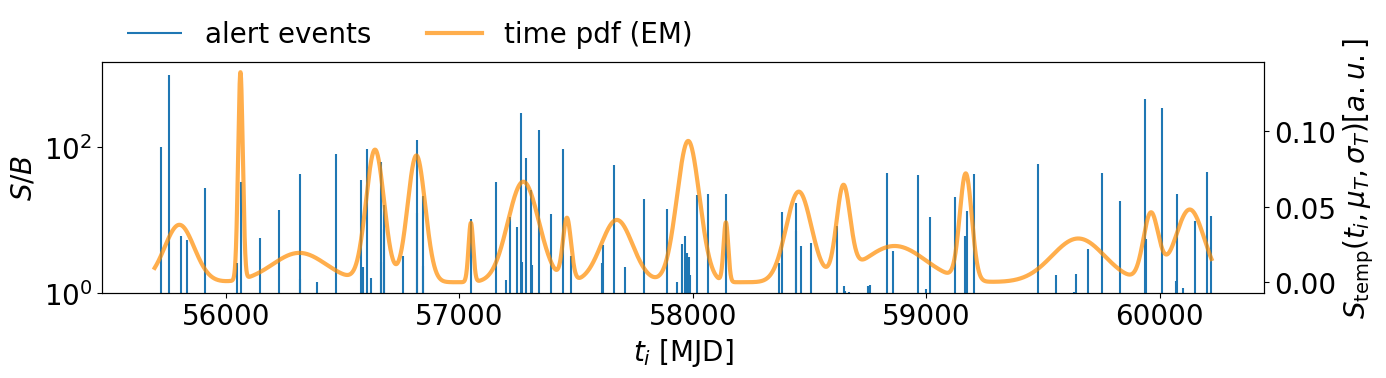

Signalness: 0.453, index: 3


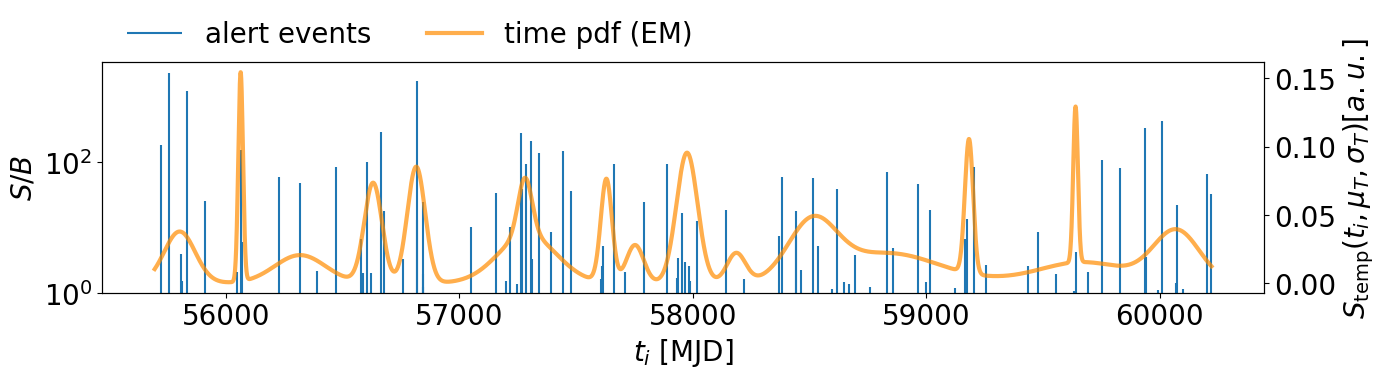

Signalness: 0.453, index: 4


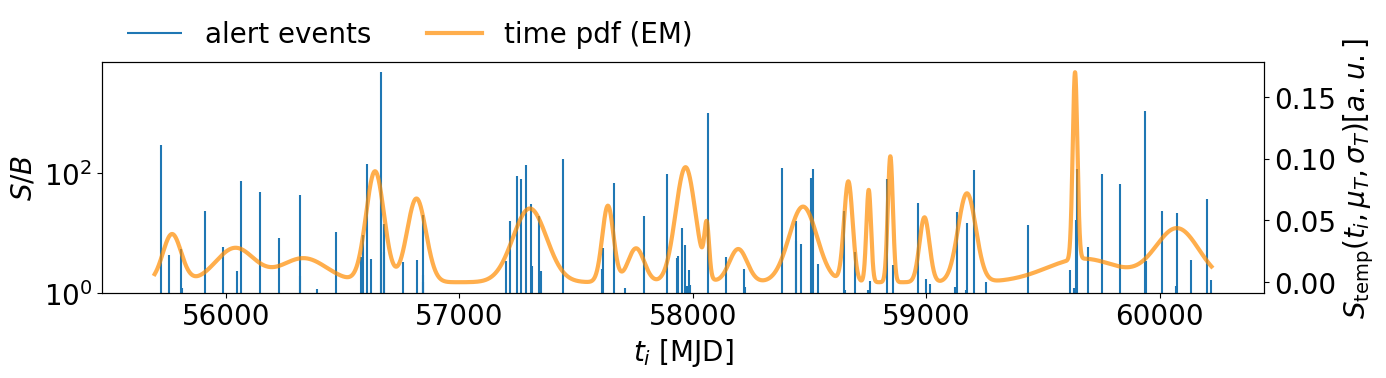

Signalness: 0.453, index: 5


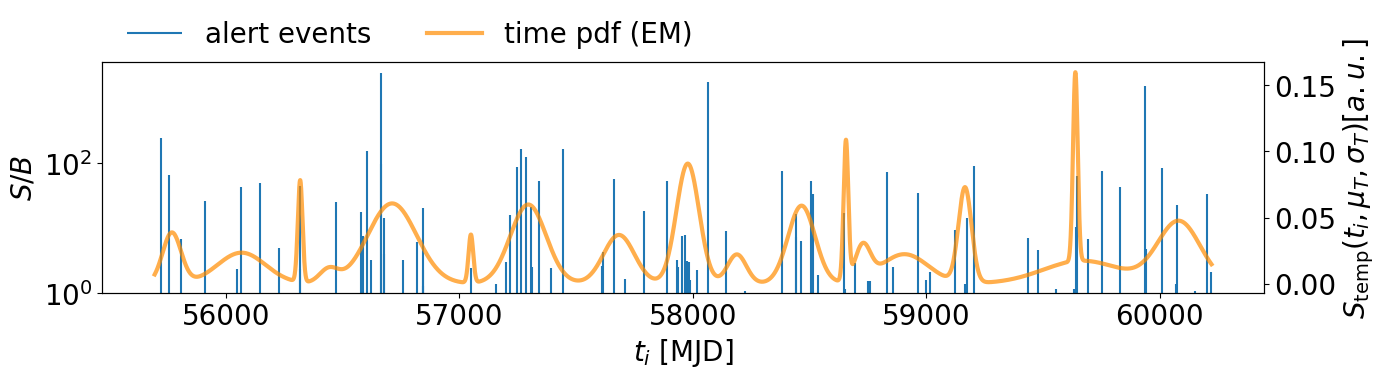

Signalness: 0.453, index: 6


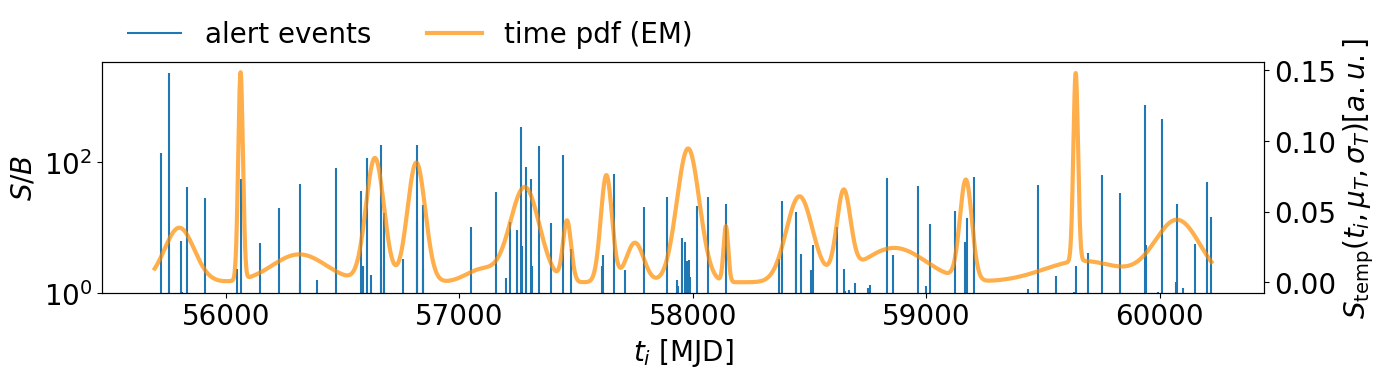

Signalness: 0.453, index: 7


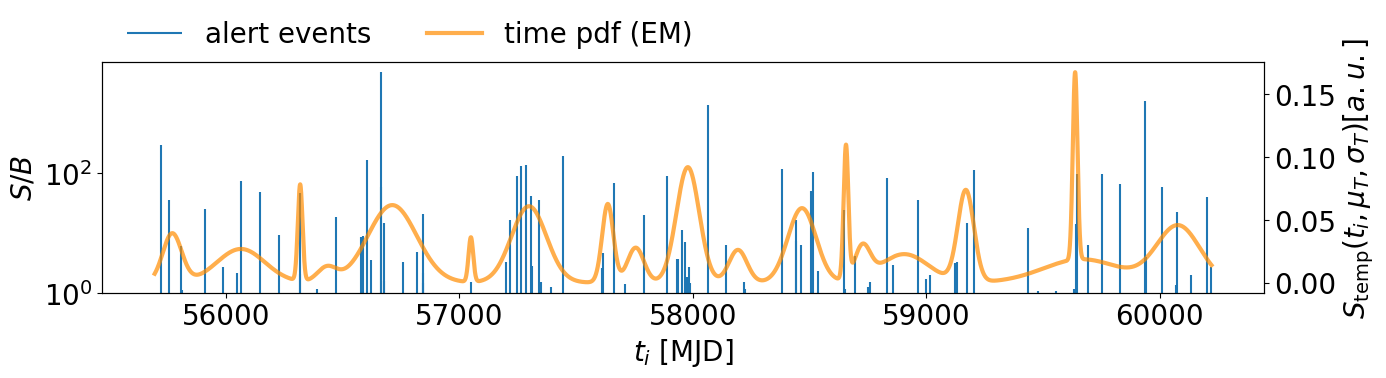

Signalness: 0.453, index: 8


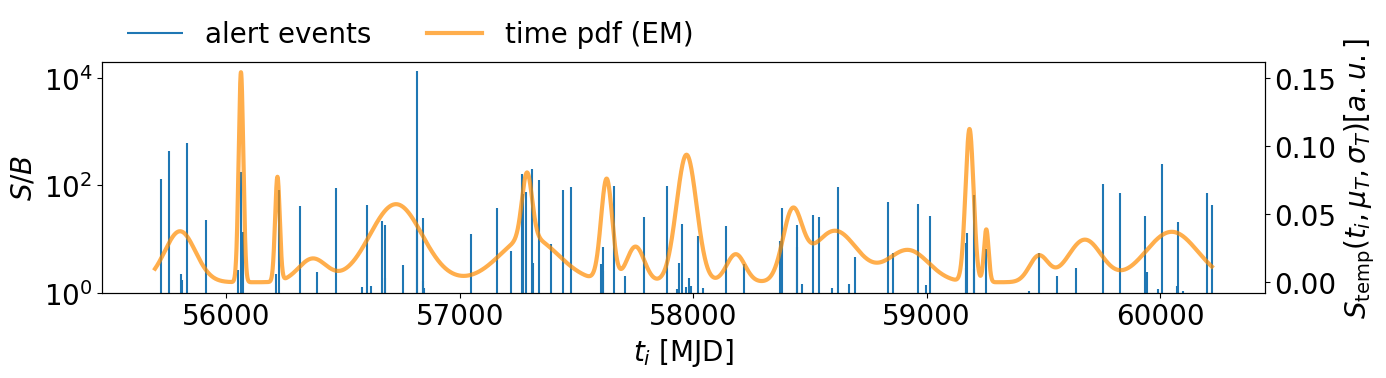

In [55]:
# sob_spatial_energy = np.load("sob_spatial_energy_for_data_area.npy", allow_pickle=True).item()
# llh_flares = np.load("llh_flares_area_with_mask.npy", allow_pickle=True).item()
for my_signalness in sob_spatial_energy:

    for index, weights in enumerate(sob_spatial_energy[my_signalness]):
        print(f"Signalness: {my_signalness:.3f}, index: {index}")
        result = llh_flares[my_signalness][index]
        signalness_mask = alerts.SIGNAL >= float(my_signalness)
        tmp_mu = result[2]
        tmp_sigma = result[3]
        tmp_ns = result[4]
        
        fig = plot_time_series(weights, tmp_mu, tmp_sigma, tmp_ns, signalness_mask)

        plt.show()
        

# Background

Create background signal over background values

In [63]:
from glob import glob
import copy

In [ ]:
# example how to run this. 

bg_ra_files = glob("/your/path/to/your/bg/right_ascension/scrambles/bg_multiplet_ra_signalness_threshold_*.npy")
bg_multiplets_files = glob("/your/path/to/your/bg_trials/bg_multiplet_list_signalness_threshold_*.npy")

weighted_x_bg, weighted_sigma_bg = {}, {}
sob_spatial = {}
sob_spatial_energy = {}

bg_alerts_all = copy.deepcopy(alerts)

for my_file in bg_ra_files:
    my_signalness = my_file.split("_")[-1].split(".npy")[0]
    
    my_ra = np.load(my_file)
    my_multiplet = np.load(my_file, allow_pickle=True)
    
    weighted_x_bg[my_signalness], weighted_sigma_bg[my_signalness] = [], []
    
    signalness_mask = alerts["SIGNAL"] >= float(my_signalness)
  
    tmp_spatial_all = []
    tmp_spatial_energy_all = []

    for trial, tmp_ra in enumerate(my_ra):
        
        bg_alerts_all["RA"] = np.rad2deg(np.random.random(len(bg_alerts_all["RA"])) * 2 * np.pi)
    
        bg_alerts_all[signalness_mask]["RA"] = tmp_ra

        tmp_x, tmp_sigma = go_through_multiplet_dict(my_multiplet[trial], bg_alerts_all[signalness_mask])
        
        if len(tmp_x) > 0:
            
            weighted_x_bg[my_signalness].append(tmp_x)
            weighted_sigma_bg[my_signalness].append(tmp_sigma)
            
            tmp_spatial = []
            tmp_spatial_energy = []
            
            for index in tmp_x:
                tmp_spatial.append(sob_distance(tmp_x[index], bg_alerts_all, alerts_area))
                tmp_spatial_energy.append(tmp_spatial[-1] * (alerts.SIGNAL / (1 - alerts.SIGNAL)))
            
        tmp_spatial_all.append(tmp_spatial)
        tmp_spatial_energy_all.append(tmp_spatial_energy)
        
    sob_spatial[my_signalness] = tmp_spatial_all
    sob_spatial_energy[my_signalness] = tmp_spatial_energy_all

Generate background files with separate skript (see "run flare fit" and "run_flare_signalness.py")

# TS distribution and p-values

For each threshold, create three plots. 
- One plot where we compare the sum of all test statistic values on the sky 
- One plot where we compare the maximal test statistic value of the sky
- One plot where we compare the best $n$ test statistic values of the sky

In [57]:
import glob

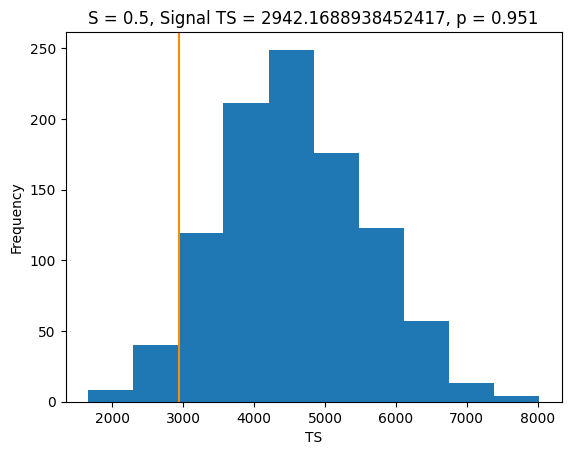

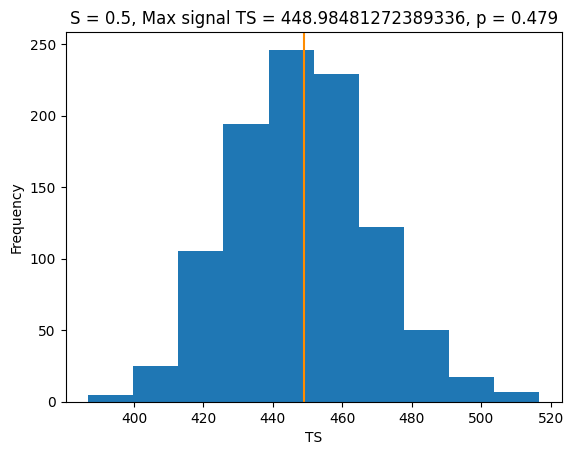

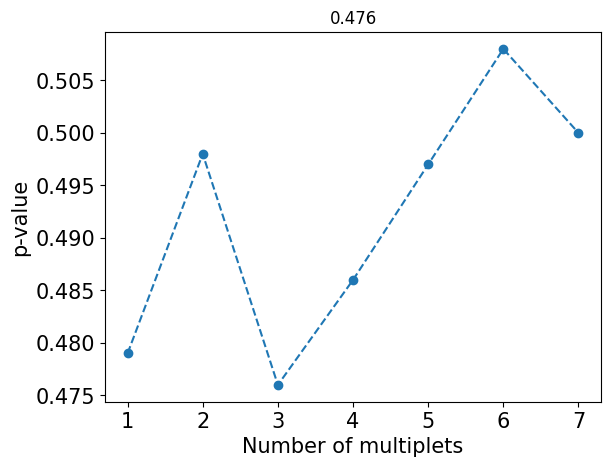

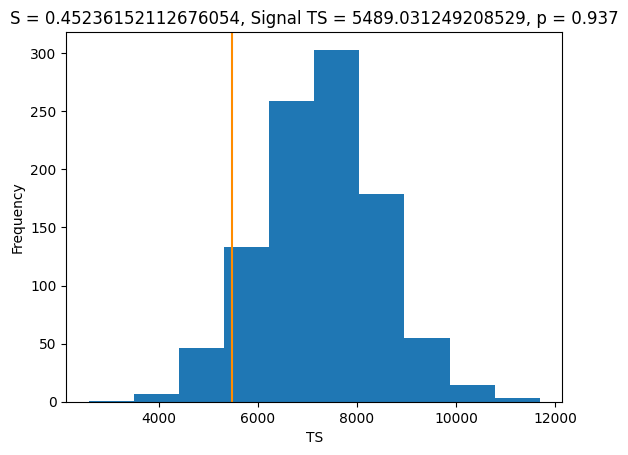

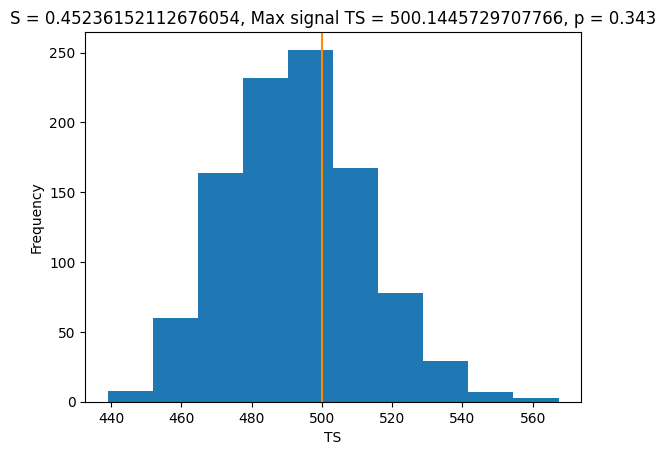

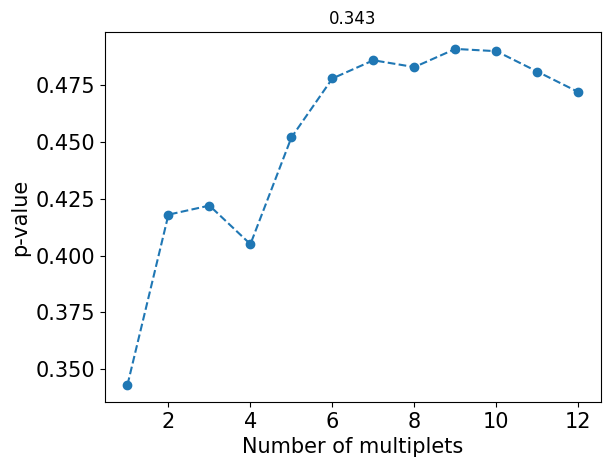

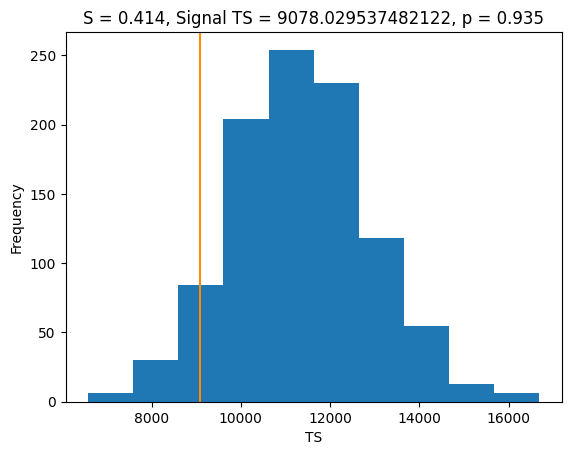

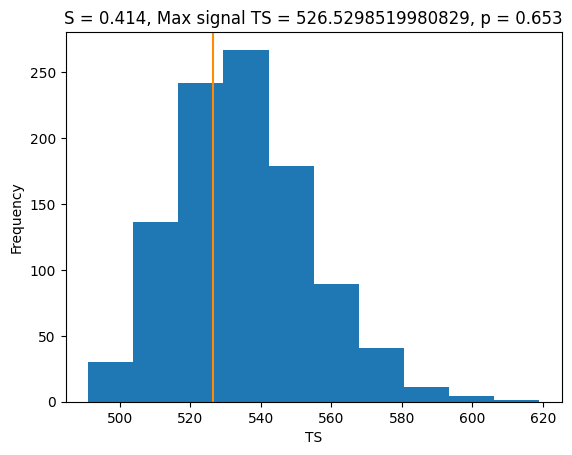

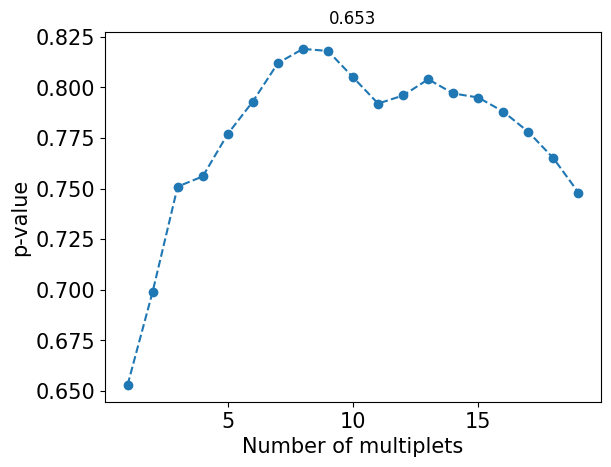

In [61]:

llh_flares_sig = np.load("../../new_alerts/llh_flares_signal_with_mask.npy", allow_pickle=True).item()

llh_bg_flares = glob.glob("../../new_alerts/bg_llh_with_signalness_cuts_*")


for path in llh_bg_flares:
    
    
    llh_flares_bg = np.load(path, allow_pickle=True).item()
    stacked_ts_bg = []
    max_ts_bg = []
    bg_ts = []
    for key in llh_flares_bg:
        
        for entry in llh_flares_bg[key]:
            tmp = entry[0]
            stacked_ts_bg.append(sum([-2*(x[1] - x[0]) for x in tmp]))
            max_ts_bg.append(max([-2*(x[1] - x[0]) for x in tmp]))
            bg_ts.append([-2*(x[1] - x[0]) for x in tmp])
            
    stacked_ts_bg = np.atleast_1d(stacked_ts_bg)
    max_ts_bg = np.atleast_1d(max_ts_bg)

    plt.hist(stacked_ts_bg)
    
    signal_ts = 0
    all_signal_ts = []
    for entry in llh_flares_sig[float(key)]:
        signal_ts += -2*(entry[1] - entry[0])
        all_signal_ts.append(-2*(entry[1] - entry[0]))
        
    max_signal_ts = max(all_signal_ts)
    plt.gca().axvline(signal_ts, color="darkorange")
    pval = sum(stacked_ts_bg >= signal_ts) / len(stacked_ts_bg)
    plt.title("S = " + str(key) + ", Signal TS = " + str(signal_ts) + ", p = " + str(pval))
    plt.xlabel("TS")
    plt.ylabel("Frequency")
    plt.show()
    
    plt.hist(max_ts_bg)
    plt.gca().axvline(max_signal_ts, color="darkorange")
    pval = sum(max_ts_bg >= max_signal_ts) / len(max_ts_bg)
    plt.title("S = " + str(key) + ", Max signal TS = " + str(max_signal_ts) + ", p = " + str(pval))
    plt.xlabel("TS")
    plt.ylabel("Frequency")
    plt.show()
    
    all_signal_ts = np.sort(all_signal_ts)
    sorted_bg = []
    for row in bg_ts:
        sorted_bg.append(np.sort(row))

    # get p-value for nth multiplet sum
    p_values_sorted = []
    for index in range(1, len(all_signal_ts)+1):
        tmp_bg_ts = []
        for row in bg_ts:
            tmp_bg_ts.append(sum(np.sort(row)[-index:]))

        sig_ts = sum(all_signal_ts[-index:])
        p_values_sorted.append(sum(tmp_bg_ts>=sig_ts) / len(tmp_bg_ts))

    fs = 15
    plt.plot(range(1, len(all_signal_ts)+1), p_values_sorted, "o--")
    ax = plt.gca()
    ax.set_xlabel("Number of multiplets", fontsize=fs)
    ax.set_ylabel(r"p-value", fontsize=fs)
    ax.tick_params(axis="both", labelsize=fs)
    plt.title(min(p_values_sorted))
    plt.show()    
    